##### Building a hybrid anomaly detection model combining a sparse autoencoder, Isolation Forest, and SVM begins by loading and cleaning your data. Select key features and split the data into training and testing sets. Normalize the data through feature scaling, which is crucial for the model's accuracy. First, use a sparse autoencoder for dimensionality reduction, making the data more manageable and focused. Then, apply an Isolation Forest to efficiently identify potential outliers, followed by an SVM to refine, and confirm the detection of anomalies with precise boundaries. Evaluate the model's effectiveness using precision, recall, the F1-score, and a confusion matrix. This sequential approach harnesses the strengths of each model component, ensuring comprehensive and effective anomaly detection.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

Epoch 1/50
138/138 [==============================] - 1s 3ms/step - loss: 0.0710 - val_loss: 0.0375
Epoch 2/50
138/138 [==============================] - 0s 3ms/step - loss: 0.0296 - val_loss: 0.0232
Epoch 3/50
138/138 [==============================] - 0s 3ms/step - loss: 0.0189 - val_loss: 0.0154
Epoch 4/50
138/138 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0109
Epoch 5/50
138/138 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0083
Epoch 6/50
138/138 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0065
Epoch 7/50
138/138 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 8/50
138/138 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 9/50
138/138 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 10/50
138/138 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0035

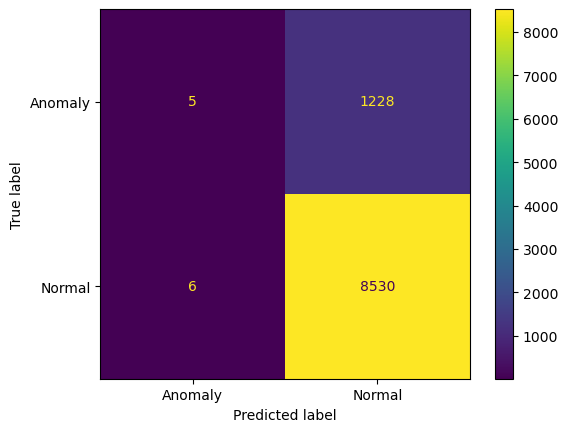

In [2]:

def hybrid_anomaly_detection():
    # Load data from a CSV file
    data = pd.read_csv('adultdata.csv')
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    data = data.drop('Sex', axis=1)
    
    X = data.drop('fnlwgt', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['fnlwgt']
    
    y = np.where(y_cont > 80000, 1, 0)  # Define `threshold` based on your domain knowledge
    
    # Select top k features; k might be adjusted based on the dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    #data.info()


    data.dropna(axis=0, inplace=True)
    
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # Define and train the autoencoder
    input_dim = X_scaled.shape[1]
    encoding_dim = 32
    input_layer = tf.keras.Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='relu', 
                           activity_regularizer=regularizers.l1(10e-5))(input_layer)
    decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = models.Model(input_layer, decoded)
    encoder = models.Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.1, verbose=1)

    # Encode the data
    X_train_encoded = encoder.predict(X_train)
    X_test_encoded = encoder.predict(X_test)
    
    # Train Isolation Forest on the encoded data
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train_encoded)
    if_train_labels = iso_forest.predict(X_train_encoded)
    
    # Filter only rows detected as normal
    normal_indices = if_train_labels == 1
    X_train_normal = X_train_encoded[normal_indices]
    y_train_normal = y_train[normal_indices]
    
    # Train SVM on the filtered normal data
    svm = SVC(kernel='rbf', gamma='auto', random_state=42)
    svm.fit(X_train_normal, y_train_normal)
    
    # Predict on the entire test dataset
    svm_predictions = svm.predict(X_test_encoded)
    
    # Evaluate the model
    precision = precision_score(y_test, svm_predictions, pos_label=1)
    recall = recall_score(y_test, svm_predictions, pos_label=1)
    f1 = f1_score(y_test, svm_predictions, pos_label=1)
    
    
    print(classification_report(y_test, svm_predictions))

    # Print metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, svm_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

# Example usage, assuming the CSV file is correctly formatted and located
hybrid_anomaly_detection()
